# Step 4C: Video Model Training (CLIP + Frame Aggregation Specialist)

This notebook fine-tunes a pre-trained CLIP model for Brawl Stars sentiment classification from videos.

**Goal**: Train the video specialist to predict post sentiment from video frames.

**Approach**: Extract multiple frames from each video, encode with CLIP, then aggregate embeddings.

**Outputs**:
- `models/video_specialist.pth` - Trained model weights
- `models/video_specialist_best.pth` - Best model weights
- `results/video_model/confusion_matrix.png` - Confusion matrix visualization
- `results/video_model/training_curves.png` - Training/validation loss and accuracy
- `results/video_model/evaluation_metrics.json` - Detailed metrics (F1, precision, recall)
- `results/video_model/training_history.json` - Epoch-by-epoch training history
- `results/video_model/evaluation_report.txt` - Human-readable classification report

## 1. Setup and Imports

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import CLIPProcessor, CLIPModel
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
import json
import os
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Try to import tqdm for notebooks, fallback to regular tqdm
try:
    from tqdm.notebook import tqdm
    print("✓ Using notebook progress bars")
except ImportError:
    from tqdm import tqdm
    print("✓ Using terminal progress bars (install ipywidgets for notebook progress bars)")

# Set random seeds for reproducibility
RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

✓ Using notebook progress bars
Using device: cuda
GPU: NVIDIA GeForce RTX 2080 SUPER
GPU Memory: 8.59 GB


## 2. Configuration

In [2]:
# Paths
TRAIN_DATA = "data/train_set.csv"
VAL_DATA = "data/validation_set.csv"
MODEL_DIR = "models"
RESULTS_DIR = "results/video_model"

# Create directories
Path(MODEL_DIR).mkdir(parents=True, exist_ok=True)
Path(RESULTS_DIR).mkdir(parents=True, exist_ok=True)

# Model configuration
MODEL_NAME = 'openai/clip-vit-base-patch32'
BATCH_SIZE = 8  # Smaller batch size for videos (multiple frames per video)
EPOCHS = 5
LEARNING_RATE = 1e-5
NUM_FRAMES = 8  # Extract 8 frames per video

# Sentiment labels
LABELS = ['Anger', 'Joy', 'Neutral/Other', 'Sadness', 'Surprise']
LABEL_TO_ID = {label: idx for idx, label in enumerate(LABELS)}
ID_TO_LABEL = {idx: label for label, idx in LABEL_TO_ID.items()}

print("Configuration:")
print(f"  Model: {MODEL_NAME}")
print(f"  Batch Size: {BATCH_SIZE}")
print(f"  Epochs: {EPOCHS}")
print(f"  Learning Rate: {LEARNING_RATE}")
print(f"  Frames per video: {NUM_FRAMES}")
print(f"  Labels: {LABELS}")

Configuration:
  Model: openai/clip-vit-base-patch32
  Batch Size: 8
  Epochs: 5
  Learning Rate: 1e-05
  Frames per video: 8
  Labels: ['Anger', 'Joy', 'Neutral/Other', 'Sadness', 'Surprise']


## 3. Data Loading and Preprocessing

In [3]:
# Load data
print("Loading datasets...")
train_df = pd.read_csv(TRAIN_DATA)
val_df = pd.read_csv(VAL_DATA)

# Filter for video posts only
train_df = train_df[train_df['media_type'] == 'video'].reset_index(drop=True)
val_df = val_df[val_df['media_type'] == 'video'].reset_index(drop=True)

print(f"Train set (videos only): {len(train_df):,} samples")
print(f"Validation set (videos only): {len(val_df):,} samples")

# Display sentiment distribution
print("\nTrain set sentiment distribution:")
print(train_df['post_sentiment'].value_counts())

print("\nValidation set sentiment distribution:")
print(val_df['post_sentiment'].value_counts())

Loading datasets...
Train set (videos only): 977 samples
Validation set (videos only): 129 samples

Train set sentiment distribution:
post_sentiment
Joy              383
Anger            269
Neutral/Other    184
Surprise         101
Sadness           40
Name: count, dtype: int64

Validation set sentiment distribution:
post_sentiment
Joy              44
Anger            39
Neutral/Other    24
Surprise         17
Sadness           5
Name: count, dtype: int64


In [4]:
# Video frame extraction function
def extract_frames(video_path, num_frames=8):
    """
    Extract evenly spaced frames from a video.
    Returns a list of PIL Images.
    """
    try:
        cap = cv2.VideoCapture(video_path)
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        
        if total_frames == 0:
            cap.release()
            return None
        
        # Calculate frame indices to extract (evenly spaced)
        frame_indices = np.linspace(0, total_frames - 1, num_frames, dtype=int)
        
        frames = []
        for idx in frame_indices:
            cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
            ret, frame = cap.read()
            
            if ret:
                # Convert BGR to RGB
                frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                # Convert to PIL Image
                pil_image = Image.fromarray(frame_rgb)
                frames.append(pil_image)
        
        cap.release()
        
        # Ensure we have exactly num_frames
        if len(frames) < num_frames:
            # Pad with last frame if needed
            while len(frames) < num_frames:
                frames.append(frames[-1] if frames else Image.new('RGB', (224, 224), color='black'))
        
        return frames[:num_frames]
    
    except Exception as e:
        print(f"Error extracting frames from {video_path}: {e}")
        return None

print("✓ Frame extraction function defined")

✓ Frame extraction function defined


In [5]:
# Custom Dataset class
class BrawlStarsVideoDataset(Dataset):
    def __init__(self, dataframe, processor, num_frames=8):
        self.data = dataframe.reset_index(drop=True)
        self.processor = processor
        self.num_frames = num_frames
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        
        # Normalize path (handle Windows backslashes)
        video_path = str(row['local_media_path']).replace('\\', '/')
        
        # Extract frames
        frames = extract_frames(video_path, self.num_frames)
        
        if frames is None or len(frames) == 0:
            # Create dummy frames if extraction fails
            print(f"Warning: Failed to extract frames from {video_path}, using dummy frames")
            frames = [Image.new('RGB', (224, 224), color='black') for _ in range(self.num_frames)]
        
        # Process all frames
        pixel_values_list = []
        for frame in frames:
            inputs = self.processor(images=frame, return_tensors="pt")
            pixel_values_list.append(inputs['pixel_values'].squeeze(0))
        
        # Stack frames: [num_frames, C, H, W]
        pixel_values = torch.stack(pixel_values_list)
        
        # Get label
        label = LABEL_TO_ID[row['post_sentiment']]
        
        return {
            'pixel_values': pixel_values,  # Shape: [num_frames, C, H, W]
            'label': torch.tensor(label, dtype=torch.long)
        }

# Initialize CLIP processor
print("Loading CLIP processor...")
processor = CLIPProcessor.from_pretrained(MODEL_NAME)

# Create datasets
train_dataset = BrawlStarsVideoDataset(train_df, processor, NUM_FRAMES)
val_dataset = BrawlStarsVideoDataset(val_df, processor, NUM_FRAMES)

# Create dataloaders (num_workers=0 to avoid issues with video loading)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f"✓ Created {len(train_loader)} train batches and {len(val_loader)} validation batches")

Loading CLIP processor...
✓ Created 123 train batches and 17 validation batches


## 4. Model Definition

In [6]:
class VideoSentimentClassifier(nn.Module):
    def __init__(self, n_classes=5, num_frames=8):
        super(VideoSentimentClassifier, self).__init__()
        self.clip = CLIPModel.from_pretrained(MODEL_NAME)
        self.num_frames = num_frames
        
        # Get CLIP's vision model output dimension
        self.vision_embed_dim = self.clip.vision_model.config.hidden_size
        
        # Temporal aggregation (attention-based)
        self.temporal_attention = nn.Sequential(
            nn.Linear(self.vision_embed_dim, 128),
            nn.Tanh(),
            nn.Linear(128, 1)
        )
        
        # Classification head
        self.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(self.vision_embed_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, n_classes)
        )
        
    def forward(self, pixel_values):
        # pixel_values shape: [batch, num_frames, C, H, W]
        batch_size, num_frames, C, H, W = pixel_values.shape
        
        # Reshape to process all frames: [batch * num_frames, C, H, W]
        pixel_values = pixel_values.view(batch_size * num_frames, C, H, W)
        
        # Get frame embeddings from CLIP
        vision_outputs = self.clip.vision_model(pixel_values=pixel_values)
        frame_embeds = vision_outputs.pooler_output  # [batch * num_frames, embed_dim]
        
        # Reshape back to [batch, num_frames, embed_dim]
        frame_embeds = frame_embeds.view(batch_size, num_frames, -1)
        
        # Compute attention weights for each frame
        attention_scores = self.temporal_attention(frame_embeds)  # [batch, num_frames, 1]
        attention_weights = torch.softmax(attention_scores, dim=1)  # [batch, num_frames, 1]
        
        # Weighted sum of frame embeddings
        video_embed = torch.sum(frame_embeds * attention_weights, dim=1)  # [batch, embed_dim]
        
        # Classification
        logits = self.classifier(video_embed)
        return logits
    
    def get_embedding(self, pixel_values):
        """Extract embedding without classification head (for Phase 2)"""
        with torch.no_grad():
            batch_size, num_frames, C, H, W = pixel_values.shape
            pixel_values = pixel_values.view(batch_size * num_frames, C, H, W)
            
            vision_outputs = self.clip.vision_model(pixel_values=pixel_values)
            frame_embeds = vision_outputs.pooler_output
            frame_embeds = frame_embeds.view(batch_size, num_frames, -1)
            
            attention_scores = self.temporal_attention(frame_embeds)
            attention_weights = torch.softmax(attention_scores, dim=1)
            video_embed = torch.sum(frame_embeds * attention_weights, dim=1)
        
        return video_embed

# Initialize model
model = VideoSentimentClassifier(n_classes=len(LABELS), num_frames=NUM_FRAMES)
model = model.to(device)

print(f"✓ Model initialized with {sum(p.numel() for p in model.parameters()):,} parameters")

✓ Model initialized with 151,574,023 parameters


## 5. Training Setup

In [7]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=2, verbose=True
)

print(f"✓ Optimizer and scheduler configured")

✓ Optimizer and scheduler configured


## 6. Training Functions

In [8]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    
    progress_bar = tqdm(dataloader, desc='Training')
    for batch in progress_bar:
        pixel_values = batch['pixel_values'].to(device)
        labels = batch['label'].to(device)
        
        # Forward pass
        outputs = model(pixel_values)
        loss = criterion(outputs, labels)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Calculate accuracy
        _, preds = torch.max(outputs, dim=1)
        correct_predictions += torch.sum(preds == labels).item()
        total_samples += labels.size(0)
        total_loss += loss.item()
        
        # Update progress bar
        progress_bar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{correct_predictions/total_samples:.4f}'
        })
    
    avg_loss = total_loss / len(dataloader)
    accuracy = correct_predictions / total_samples
    
    return avg_loss, accuracy


def eval_model(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        progress_bar = tqdm(dataloader, desc='Validation')
        for batch in progress_bar:
            pixel_values = batch['pixel_values'].to(device)
            labels = batch['label'].to(device)
            
            outputs = model(pixel_values)
            loss = criterion(outputs, labels)
            
            _, preds = torch.max(outputs, dim=1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            total_loss += loss.item()
    
    avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    
    return avg_loss, accuracy, f1, all_preds, all_labels

print("✓ Training functions defined")

✓ Training functions defined


## 7. Training Loop

In [9]:
# Training history
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'val_f1': []
}

best_val_f1 = 0
best_epoch = 0

print("=" * 80)
print("STARTING TRAINING")
print("=" * 80)

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch + 1}/{EPOCHS}")
    print("-" * 80)
    
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Validate
    val_loss, val_acc, val_f1, _, _ = eval_model(model, val_loader, criterion, device)
    
    # Update learning rate
    scheduler.step(val_f1)
    
    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_f1'].append(val_f1)
    
    # Print metrics
    print(f"\nResults:")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"  Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f} | Val F1: {val_f1:.4f}")
    
    # Save best model
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        best_epoch = epoch + 1
        torch.save(model.state_dict(), f"{MODEL_DIR}/video_specialist_best.pth")
        print(f"  ✓ New best model saved! (F1: {val_f1:.4f})")

print("\n" + "=" * 80)
print("TRAINING COMPLETE")
print("=" * 80)
print(f"Best validation F1: {best_val_f1:.4f} (Epoch {best_epoch})")

STARTING TRAINING

Epoch 1/5
--------------------------------------------------------------------------------


Training:   0%|          | 0/123 [00:00<?, ?it/s]

Validation:   0%|          | 0/17 [00:00<?, ?it/s]


Results:
  Train Loss: 1.4330 | Train Acc: 0.3736
  Val Loss:   1.4124 | Val Acc:   0.3411 | Val F1: 0.2489
  ✓ New best model saved! (F1: 0.2489)

Epoch 2/5
--------------------------------------------------------------------------------


Training:   0%|          | 0/123 [00:00<?, ?it/s]

Validation:   0%|          | 0/17 [00:00<?, ?it/s]


Results:
  Train Loss: 1.3663 | Train Acc: 0.4401
  Val Loss:   1.4107 | Val Acc:   0.3721 | Val F1: 0.2737
  ✓ New best model saved! (F1: 0.2737)

Epoch 3/5
--------------------------------------------------------------------------------


Training:   0%|          | 0/123 [00:00<?, ?it/s]

Validation:   0%|          | 0/17 [00:00<?, ?it/s]


Results:
  Train Loss: 1.2881 | Train Acc: 0.4872
  Val Loss:   1.4243 | Val Acc:   0.4341 | Val F1: 0.3498
  ✓ New best model saved! (F1: 0.3498)

Epoch 4/5
--------------------------------------------------------------------------------


Training:   0%|          | 0/123 [00:00<?, ?it/s]

Validation:   0%|          | 0/17 [00:00<?, ?it/s]


Results:
  Train Loss: 1.2017 | Train Acc: 0.5507
  Val Loss:   1.4736 | Val Acc:   0.4186 | Val F1: 0.3745
  ✓ New best model saved! (F1: 0.3745)

Epoch 5/5
--------------------------------------------------------------------------------


Training:   0%|          | 0/123 [00:00<?, ?it/s]

Validation:   0%|          | 0/17 [00:00<?, ?it/s]


Results:
  Train Loss: 1.0116 | Train Acc: 0.6325
  Val Loss:   1.5889 | Val Acc:   0.4109 | Val F1: 0.3602

TRAINING COMPLETE
Best validation F1: 0.3745 (Epoch 4)


## 8. Save Final Model

In [10]:
# Save final model
torch.save(model.state_dict(), f"{MODEL_DIR}/video_specialist.pth")
print(f"✓ Final model saved to {MODEL_DIR}/video_specialist.pth")

# Save training history
with open(f"{RESULTS_DIR}/training_history.json", 'w') as f:
    json.dump(history, f, indent=2)
print(f"✓ Training history saved to {RESULTS_DIR}/training_history.json")

✓ Final model saved to models/video_specialist.pth
✓ Training history saved to results/video_model/training_history.json


## 9. Load Best Model for Evaluation

In [11]:
# Load best model
model.load_state_dict(torch.load(f"{MODEL_DIR}/video_specialist_best.pth"))
print(f"✓ Loaded best model (Epoch {best_epoch}, F1: {best_val_f1:.4f})")

✓ Loaded best model (Epoch 4, F1: 0.3745)


## 10. Final Evaluation and Metrics

In [12]:
# Evaluate on validation set
print("Evaluating on validation set...")
val_loss, val_acc, val_f1, val_preds, val_labels = eval_model(model, val_loader, criterion, device)

print(f"\nFinal Validation Metrics:")
print(f"  Loss: {val_loss:.4f}")
print(f"  Accuracy: {val_acc:.4f}")
print(f"  Weighted F1: {val_f1:.4f}")

Evaluating on validation set...


Validation:   0%|          | 0/17 [00:00<?, ?it/s]


Final Validation Metrics:
  Loss: 1.4736
  Accuracy: 0.4186
  Weighted F1: 0.3745


In [13]:
# Generate classification report
report = classification_report(val_labels, val_preds, target_names=LABELS, digits=4)
print("\nClassification Report:")
print(report)

# Save classification report
with open(f"{RESULTS_DIR}/evaluation_report.txt", 'w') as f:
    f.write("VIDEO MODEL (CLIP + Temporal Attention) EVALUATION REPORT\n")
    f.write("=" * 80 + "\n\n")
    f.write(f"Model: {MODEL_NAME}\n")
    f.write(f"Frames per video: {NUM_FRAMES}\n")
    f.write(f"Best Epoch: {best_epoch}\n")
    f.write(f"Validation Loss: {val_loss:.4f}\n")
    f.write(f"Validation Accuracy: {val_acc:.4f}\n")
    f.write(f"Validation Weighted F1: {val_f1:.4f}\n\n")
    f.write("Classification Report:\n")
    f.write(report)

print(f"\n✓ Evaluation report saved to {RESULTS_DIR}/evaluation_report.txt")


Classification Report:
               precision    recall  f1-score   support

        Anger     0.4091    0.4615    0.4337        39
          Joy     0.4833    0.6591    0.5577        44
Neutral/Other     0.2800    0.2917    0.2857        24
      Sadness     0.0000    0.0000    0.0000         5
     Surprise     0.0000    0.0000    0.0000        17

     accuracy                         0.4186       129
    macro avg     0.2345    0.2825    0.2554       129
 weighted avg     0.3406    0.4186    0.3745       129


✓ Evaluation report saved to results/video_model/evaluation_report.txt


In [14]:
# Generate detailed metrics JSON
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1_per_class, support = precision_recall_fscore_support(
    val_labels, val_preds, labels=range(len(LABELS))
)

metrics = {
    "overall": {
        "accuracy": float(val_acc),
        "weighted_f1": float(val_f1),
        "loss": float(val_loss)
    },
    "per_class": {}
}

for idx, label in enumerate(LABELS):
    metrics["per_class"][label] = {
        "precision": float(precision[idx]),
        "recall": float(recall[idx]),
        "f1_score": float(f1_per_class[idx]),
        "support": int(support[idx])
    }

# Save metrics
with open(f"{RESULTS_DIR}/evaluation_metrics.json", 'w') as f:
    json.dump(metrics, f, indent=2)

print(f"✓ Detailed metrics saved to {RESULTS_DIR}/evaluation_metrics.json")

✓ Detailed metrics saved to results/video_model/evaluation_metrics.json


## 11. Visualizations

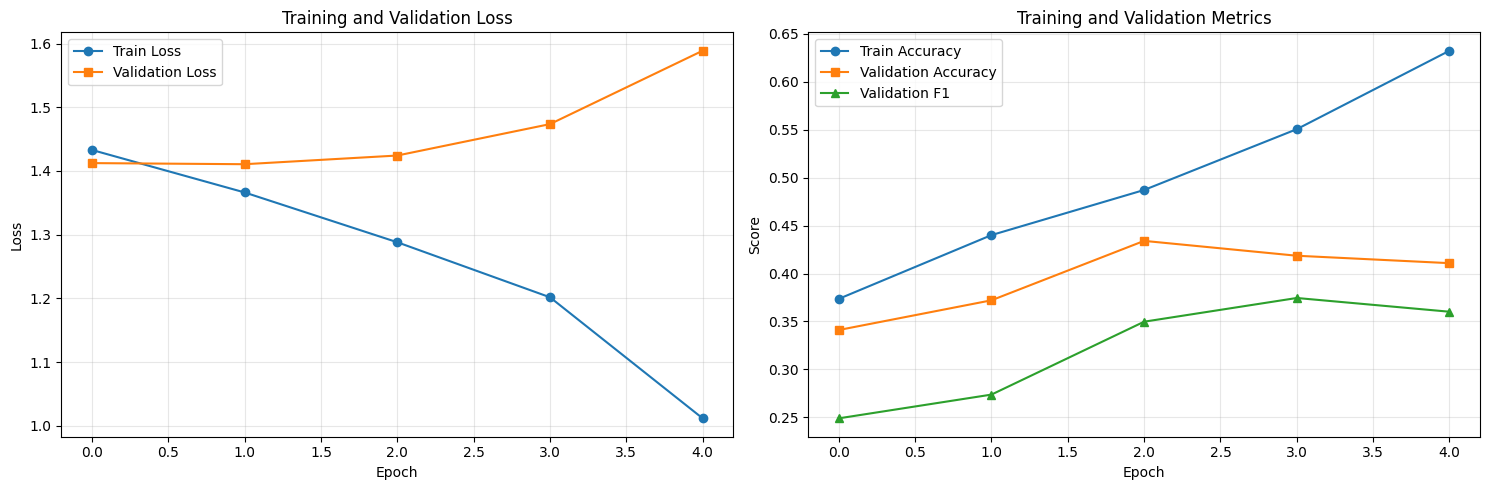

✓ Training curves saved to results/video_model/training_curves.png


In [15]:
# Plot training curves
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
axes[0].plot(history['train_loss'], label='Train Loss', marker='o')
axes[0].plot(history['val_loss'], label='Validation Loss', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy plot
axes[1].plot(history['train_acc'], label='Train Accuracy', marker='o')
axes[1].plot(history['val_acc'], label='Validation Accuracy', marker='s')
axes[1].plot(history['val_f1'], label='Validation F1', marker='^')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Score')
axes[1].set_title('Training and Validation Metrics')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f"{RESULTS_DIR}/training_curves.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Training curves saved to {RESULTS_DIR}/training_curves.png")

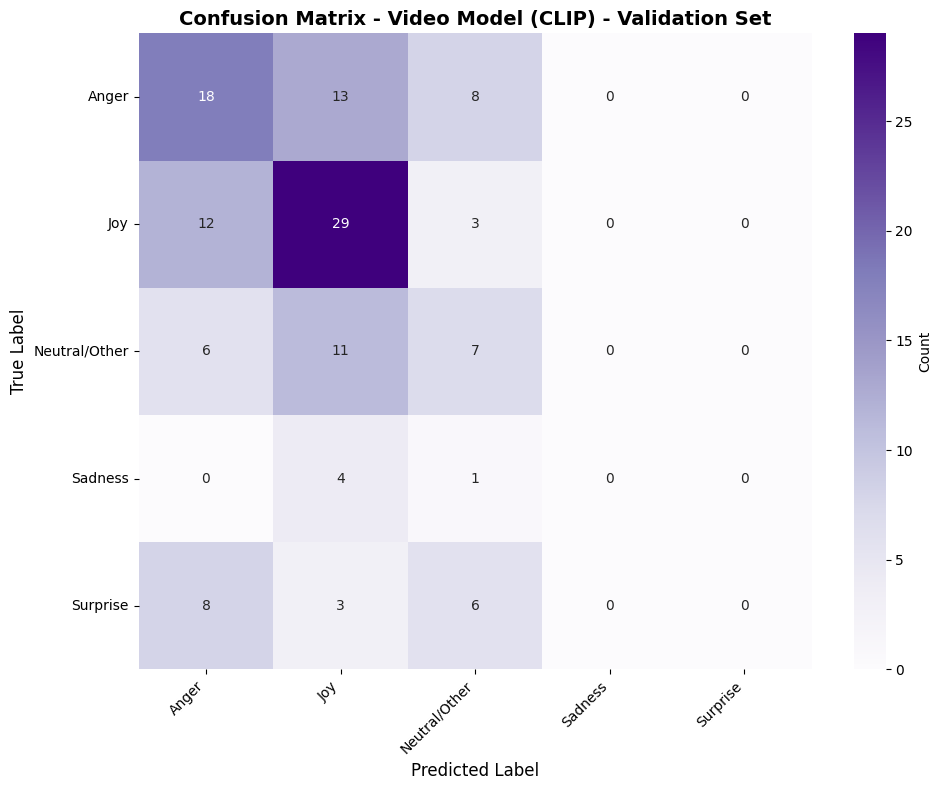

✓ Confusion matrix saved to results/video_model/confusion_matrix.png


In [16]:
# Plot confusion matrix
cm = confusion_matrix(val_labels, val_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Purples',
    xticklabels=LABELS,
    yticklabels=LABELS,
    cbar_kws={'label': 'Count'}
)
plt.title('Confusion Matrix - Video Model (CLIP) - Validation Set', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(f"{RESULTS_DIR}/confusion_matrix.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Confusion matrix saved to {RESULTS_DIR}/confusion_matrix.png")

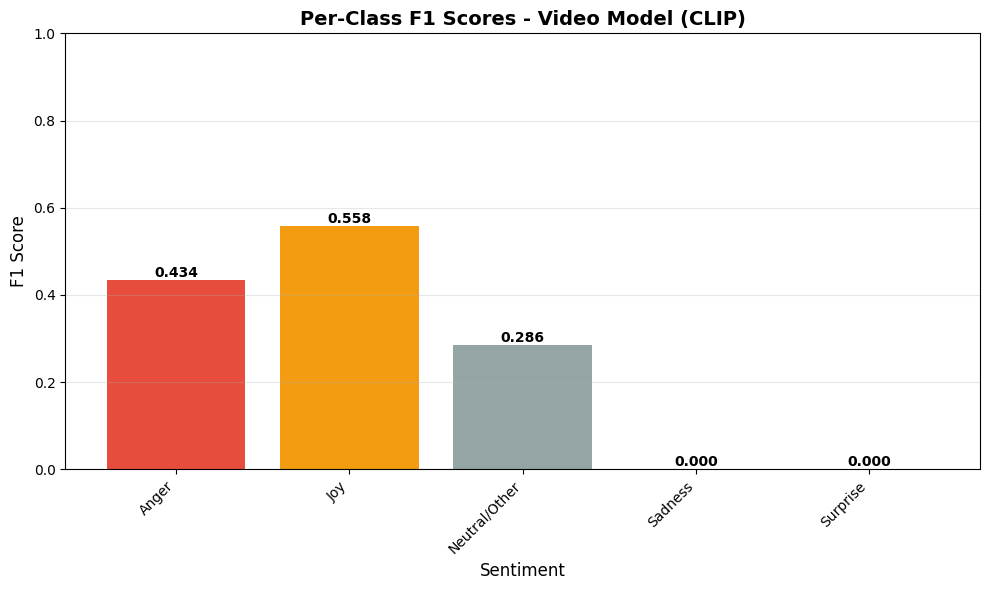

✓ Per-class F1 scores plot saved to results/video_model/f1_scores_per_class.png


In [17]:
# Plot per-class F1 scores
f1_scores = [metrics['per_class'][label]['f1_score'] for label in LABELS]

plt.figure(figsize=(10, 6))
bars = plt.bar(LABELS, f1_scores, color=['#e74c3c', '#f39c12', '#95a5a6', '#3498db', '#9b59b6'])
plt.xlabel('Sentiment', fontsize=12)
plt.ylabel('F1 Score', fontsize=12)
plt.title('Per-Class F1 Scores - Video Model (CLIP)', fontsize=14, fontweight='bold')
plt.ylim(0, 1.0)
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, score in zip(bars, f1_scores):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{score:.3f}',
             ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig(f"{RESULTS_DIR}/f1_scores_per_class.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Per-class F1 scores plot saved to {RESULTS_DIR}/f1_scores_per_class.png")

## 12. Summary

In [18]:
print("=" * 80)
print("VIDEO MODEL (CLIP + TEMPORAL ATTENTION) TRAINING COMPLETE!")
print("=" * 80)
print("\nFiles Generated:")
print(f"  1. Model weights: {MODEL_DIR}/video_specialist.pth")
print(f"  2. Best model weights: {MODEL_DIR}/video_specialist_best.pth")
print(f"  3. Training history: {RESULTS_DIR}/training_history.json")
print(f"  4. Evaluation metrics: {RESULTS_DIR}/evaluation_metrics.json")
print(f"  5. Evaluation report: {RESULTS_DIR}/evaluation_report.txt")
print(f"  6. Training curves: {RESULTS_DIR}/training_curves.png")
print(f"  7. Confusion matrix: {RESULTS_DIR}/confusion_matrix.png")
print(f"  8. F1 scores per class: {RESULTS_DIR}/f1_scores_per_class.png")

print("\nFinal Performance:")
print(f"  Accuracy: {val_acc:.4f}")
print(f"  Weighted F1: {val_f1:.4f}")
print(f"  Best Epoch: {best_epoch}/{EPOCHS}")

print("\nPer-Class F1 Scores:")
for label in LABELS:
    f1 = metrics['per_class'][label]['f1_score']
    support = metrics['per_class'][label]['support']
    print(f"  {label:15s}: {f1:.4f} (n={support})")

print("\n" + "=" * 80)
print("Next Step: Train Fusion Model (Phase 2) - Step 5")
print("=" * 80)

VIDEO MODEL (CLIP + TEMPORAL ATTENTION) TRAINING COMPLETE!

Files Generated:
  1. Model weights: models/video_specialist.pth
  2. Best model weights: models/video_specialist_best.pth
  3. Training history: results/video_model/training_history.json
  4. Evaluation metrics: results/video_model/evaluation_metrics.json
  5. Evaluation report: results/video_model/evaluation_report.txt
  6. Training curves: results/video_model/training_curves.png
  7. Confusion matrix: results/video_model/confusion_matrix.png
  8. F1 scores per class: results/video_model/f1_scores_per_class.png

Final Performance:
  Accuracy: 0.4186
  Weighted F1: 0.3745
  Best Epoch: 4/5

Per-Class F1 Scores:
  Anger          : 0.4337 (n=39)
  Joy            : 0.5577 (n=44)
  Neutral/Other  : 0.2857 (n=24)
  Sadness        : 0.0000 (n=5)
  Surprise       : 0.0000 (n=17)

Next Step: Train Fusion Model (Phase 2) - Step 5
